In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#for reading images and manipulating images
import cv2

# for label encoding the target variable
from sklearn.preprocessing import LabelEncoder

# for tensor based operations
from tensorflow.keras.utils import to_categorical, normalize

# for ML
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# for face detection 
from mtcnn.mtcnn import MTCNN

In [2]:
train = pd.read_csv("train.csv")
train.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [3]:
train.shape

(15412, 6)

In [4]:
len(train["name"].unique())

4326

In [5]:
train["classname"].unique()

array(['face_with_mask', 'mask_colorful', 'face_no_mask',
       'face_with_mask_incorrect', 'mask_surgical', 'face_other_covering',
       'scarf_bandana', 'eyeglasses', 'helmet', 'face_shield',
       'sunglasses', 'hood', 'hat', 'goggles', 'hair_net', 'hijab_niqab',
       'other', 'gas_mask', 'balaclava_ski_mask', 'turban'], dtype=object)

In [6]:
# select those only having classname as face_with_mask and no_mask
options = ["face_with_mask","face_no_mask"]

# rearrange the database with the selected options and reset index
train = train[train["classname"].isin(options)].reset_index(drop=True)
train.sort_values("name", axis=0, inplace=True)

In [7]:
train["classname"].unique()

array(['face_no_mask', 'face_with_mask'], dtype=object)

In [8]:
train.head()

,name,x1,x2,y1,y2,classname
4974,1801.jpg,451,186,895,697,face_no_mask
1327,1802.jpg,110,71,273,272,face_with_mask
5524,1803.jpg,126,75,303,333,face_with_mask
2214,1804.jpg,112,113,262,307,face_with_mask
2330,1805.jpg,728,180,853,336,face_with_mask


<BarContainer object of 2 artists>

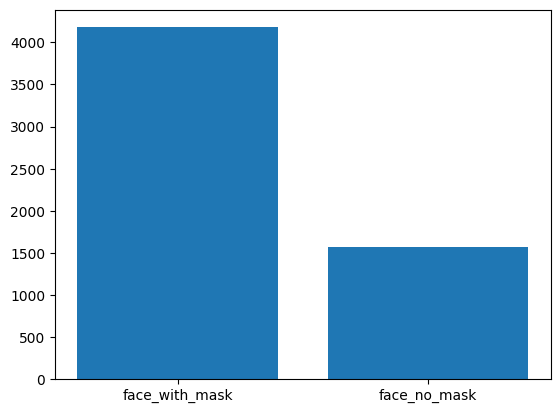

In [9]:
x_axis = ["face_with_mask", "face_no_mask"]
y_axis = train.classname.value_counts()
plt.bar(x_axis, y_axis)

In [10]:
# fetch actual images
images_file_path = (r"D:\ML_Practice\Face_Mask_Detection\Medical mask\Medical mask\Medical Mask\images")
print(images_file_path)

D:\ML_Practice\Face_Mask_Detection\Medical mask\Medical mask\Medical Mask\images


In [11]:
image_filenames = os.listdir(images_file_path)
print(len(image_filenames))

6024


In [12]:
# linking the actual images to train dataset(trial only for 1st element)
sample_image_name = train.iloc[0]["name"]
sample_image_file_path = images_file_path + "\\" + sample_image_name

print(sample_image_file_path)

D:\ML_Practice\Face_Mask_Detection\Medical mask\Medical mask\Medical Mask\images\1801.jpg


In [13]:
img = plt.imread(sample_image_file_path)

In [14]:
img.shape

(1385, 1386, 3)

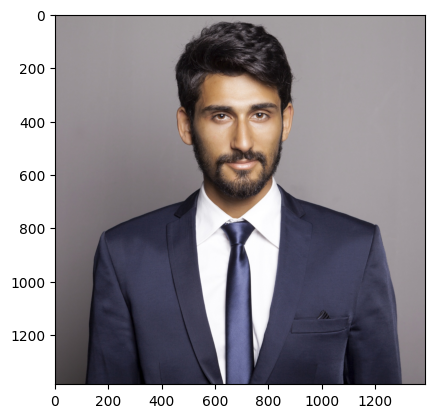

In [15]:
# creating a figure and subplot axis
fig, ax = plt.subplots()

ax.imshow(img)

In [16]:
# select rows with same image name as in name column of train dataset
sel_df = train[train["name"] == sample_image_name]

# convert all the available bounding box values into a list
bbox = sel_df[["x1", "x2", "y1", "y2"]].values.tolist()

print(bbox)

[[451, 186, 895, 697]]


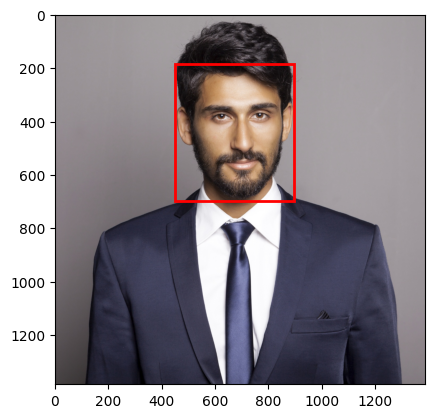

In [17]:
fig, ax = plt.subplots()
ax.imshow(img)

for box in bbox:
    x1, x2, y1, y2 = box
    
    xy = (x1, x2)
    width = y1 - x1
    height = y2 - x2
    
    rect = patches.Rectangle(xy, width, height, linewidth=2, edgecolor="r", facecolor="none")
    
    ax.add_patch(rect)

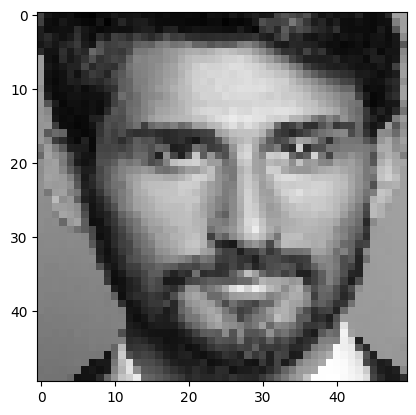

In [18]:
img_size = 50
data = []

for index, row in train.iterrows():
    
    # single row
    name, x1, x2, y1, y2, classname = row.values
    
    # full file path
    full_file_path = images_file_path + "\\" + name
    
    # reading in the image as array as grayscale image
    img_array = cv2.imread(full_file_path, cv2.IMREAD_GRAYSCALE)
    
    crop_image = img_array[x2:y2, x1:y1]
    
    new_image_array = cv2.resize(crop_image, (img_size, img_size))
    
    data.append([new_image_array, classname])

plt.imshow(data[0][0], cmap="gray")

In [19]:
x = []
y = []

for features, labels in data:
    x.append(features)
    y.append(labels)
    

In [20]:
# Reshaping the feature array (Number of images, IMG_SIZE, IMG_SIZE, Color depth)
x = np.array(x).reshape(-1, 50, 50, 1)
# Normalizing
x = normalize(x, axis=1)
# Label encoding y
lbl = LabelEncoder()
y = lbl.fit_transform(y)
# Converting it into a categorical variable
y = to_categorical(y)

In [21]:
print(x.shape)

(5749, 50, 50, 1)


In [22]:
input_img_shape = x.shape[1:]
print(input_img_shape)

(50, 50, 1)


In [24]:
    # Initializing a sequential keras model
    model = Sequential()

    # Adding a 2D convolution layer
    model.add(
        Conv2D(
            filters=100,
            kernel_size=(3, 3),
            use_bias=True,
            input_shape=input_img_shape,
            activation="relu",
            strides=2,
        )
    )

    # Adding a max-pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Adding a 2D convolution layer - Output Shape = 10 x 10 x 64
    model.add(Conv2D(filters=64, kernel_size=(3, 3), use_bias=True, activation="relu"))

    # Adding a max-pooling layer - Output Shape = 5 x 5 x 64
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Adding a flatten layer - Output Shape = 5 x 5 x 64 = 1600
    model.add(Flatten())

    # Adding a dense layer - Output Shape = 50
    model.add(Dense(50, activation="relu"))

    # Adding a dropout
    model.add(Dropout(0.2))

    # Adding a dense layer with softmax activation
    model.add(Dense(2, activation="softmax"))

    # Printing the model summary
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 100)       1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        57664     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 50)               

In [27]:
# Initializing an Adam optimizer
opt = Adam(learning_rate=1e-3, weight_decay=1e-5)

# Configuring the model for training
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model
model.fit(x, y, epochs=30, batch_size=5)

Epoch 1/30
1150/1150 [==============================] - 6s 4ms/step - loss: 0.5597 - accuracy: 0.7266
Epoch 2/30
1150/1150 [==============================] - 5s 4ms/step - loss: 0.4881 - accuracy: 0.7568
Epoch 3/30
1150/1150 [==============================] - 5s 4ms/step - loss: 0.4333 - accuracy: 0.8040
Epoch 4/30
1150/1150 [==============================] - 5s 4ms/step - loss: 0.3958 - accuracy: 0.8243
Epoch 5/30
1150/1150 [==============================] - 5s 5ms/step - loss: 0.3608 - accuracy: 0.8436
Epoch 6/30
1150/1150 [==============================] - 6s 5ms/step - loss: 0.3324 - accuracy: 0.8568
Epoch 7/30
1150/1150 [==============================] - 6s 5ms/step - loss: 0.3065 - accuracy: 0.8702
Epoch 8/30
1150/1150 [==============================] - 6s 5ms/step - loss: 0.2797 - accuracy: 0.8782
Epoch 9/30
1150/1150 [==============================] - 6s 5ms/step - loss: 0.2674 - accuracy: 0.8831
Epoch 10/30
1150/1150 [==============================] - 6s 5ms/step - loss: 0.249

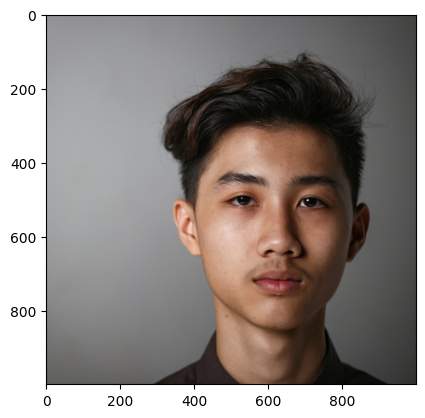

In [41]:
# Image file path for sample image
test_image_file_path = "D:\ML_Practice\Face_Mask_Detection\photo-1542909168-82c3e7fdca5c.jpg"

# Loading in the image
img = plt.imread(test_image_file_path)

# Showing the image
plt.imshow(img)

In [42]:
# Initializing the detector
detector = MTCNN()

# Detecting the faces in the image
faces = detector.detect_faces(img)

print(faces)

1/1 [==============================] - 0s 319ms/step
[{'box': [393, 260, 431, 594], 'confidence': 0.9999971389770508, 'keypoints': {'left_eye': (533, 505), 'right_eye': (720, 511), 'nose': (642, 618), 'mouth_left': (552, 722), 'mouth_right': (704, 722)}}]


1/1 [==============================] - 0s 333ms/step


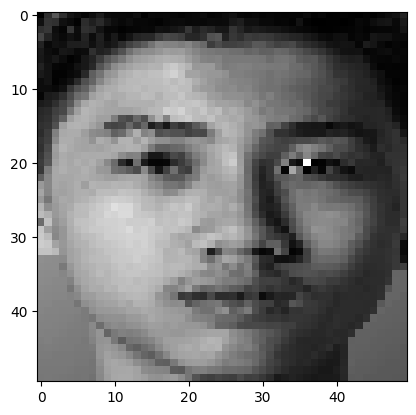

In [43]:
# Reading in the image as a grayscale image
img_array = cv2.imread(test_image_file_path, cv2.IMREAD_GRAYSCALE)

# Initializing the detector
detector = MTCNN()

# Detecting the faces in the image
faces = detector.detect_faces(img)

# Getting the values for bounding box
x1, x2, width, height = faces[0]["box"]

# Selecting the portion covered by the bounding box
crop_image = img_array[x2 : x2 + height, x1 : x1 + width]

# Resizing the image
new_img_array = cv2.resize(crop_image, (img_size, img_size))

# Plotting the image
plt.imshow(new_img_array, cmap="gray")

In [44]:
# Reshaping the image
x = new_img_array.reshape(-1, 50, 50, 1)

# Normalizing
x = normalize(x, axis=1)

In [45]:
prediction = model.predict(x)
print(prediction)

1/1 [==============================] - 0s 55ms/step
[[9.9991107e-01 8.8890163e-05]]


In [46]:
# Returns the index of the maximum value
np.argmax(prediction)

0

In [51]:
import numpy as np

# Assuming prediction is the output obtained from model.predict(x)
prediction = np.array([[0]])  # Replace this with your actual prediction

# Convert the probabilities to class labels
class_labels = ["face_with_mask", "face_no_mask"]
predicted_class = class_labels[np.argmax(prediction)]

print("Predicted class:", predicted_class)


Predicted class: face_with_mask
